## PySpark Setup

In [1]:
# Download Java and Spark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
# Set up the paths

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
# Create a Spark session

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark.conf.set("spark.sql.caseSensitive", True) # Avoid error "Found duplicate column(s) in the data schema"
spark

## PySpark MLlib Linear Regression

In [31]:
# Import required PySpark modules
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
import numpy as np
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

### <font color=blue>Upload the file "cruise_ship_info.csv" to the runtime</font>

### <font color=blue>Use Spark MLlib to build a linear regression model to predict the number of crew members (i.e., the "crew" column)</font>

In [32]:
# First load the data (be sure it is uploaded in the runtime)
cruise = spark.read.csv('cruise_ship_info.csv', header = True, inferSchema=True)

# Take a look
cruise.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [33]:
cruise.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     null|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

### Key Assumptions of Linear Regression:
* Linearity: The relationship between independent variables and the
dependent variable should be linear.
* Normality of Residuals: Residuals (errors) should be normally distributed.
* Homoscedasticity: Constant variance of residuals (no pattern in the spread of residuals).
* No Autocorrelation of Residuals: Residuals should not be correlated with each other.
* No Multicollinearity: Independent variables should not be highly correlated with each other.

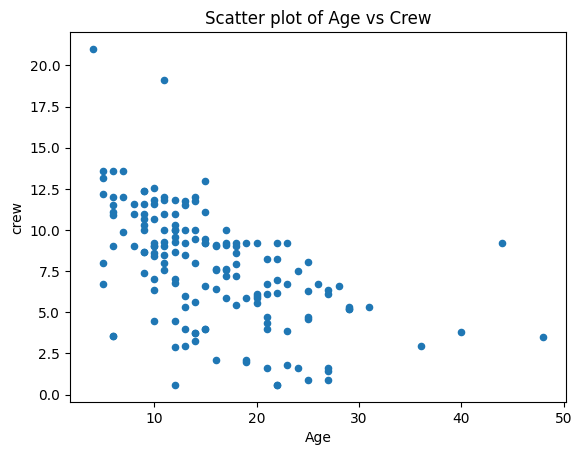

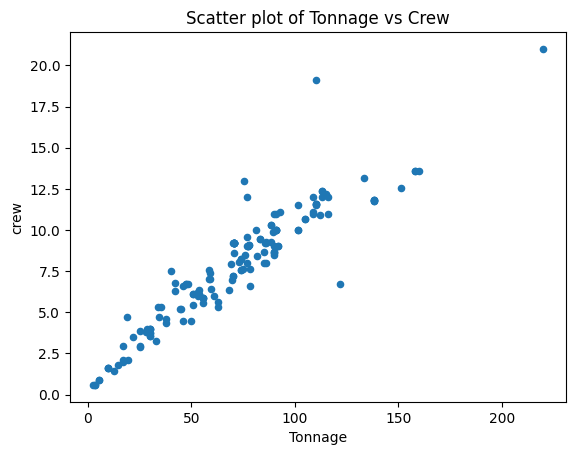

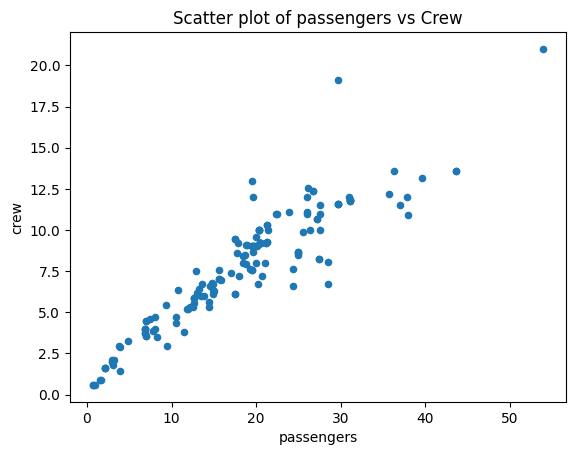

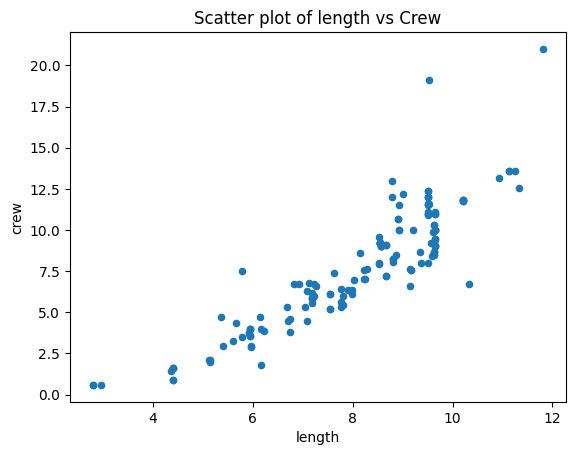

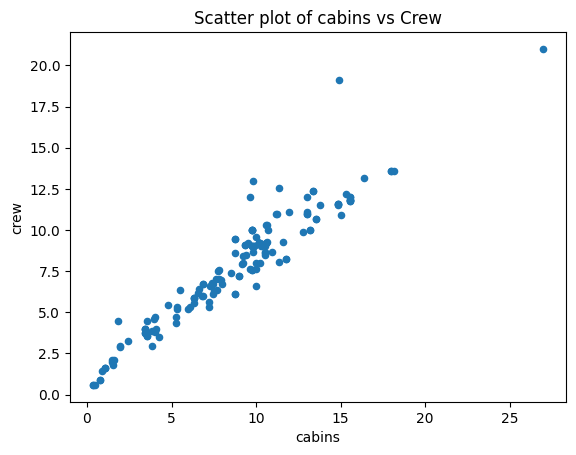

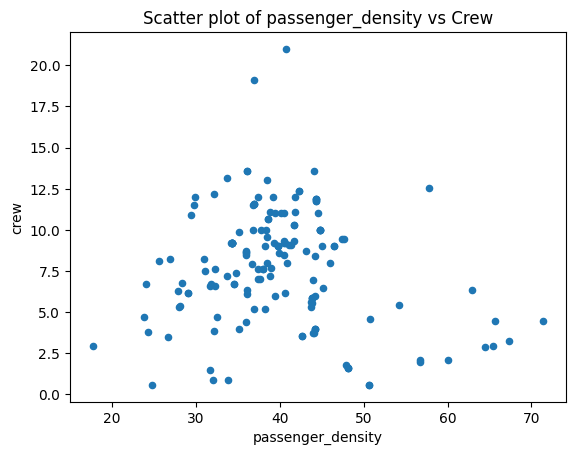

In [34]:
# 1. Linearity: Check the relationship between each independent variable and the dependent variable
# Plot scatter plots of each feature against the target variable 'crew'
features = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
for feature in features:
    cruise.select(feature, 'crew').toPandas().plot(kind='scatter', x=feature, y='crew', title=f'Scatter plot of {feature} vs Crew')
    plt.show()


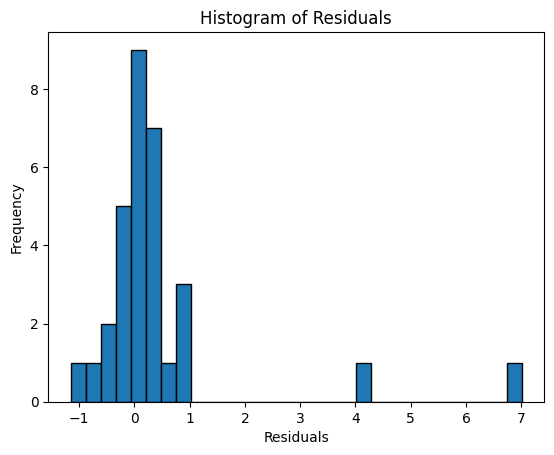

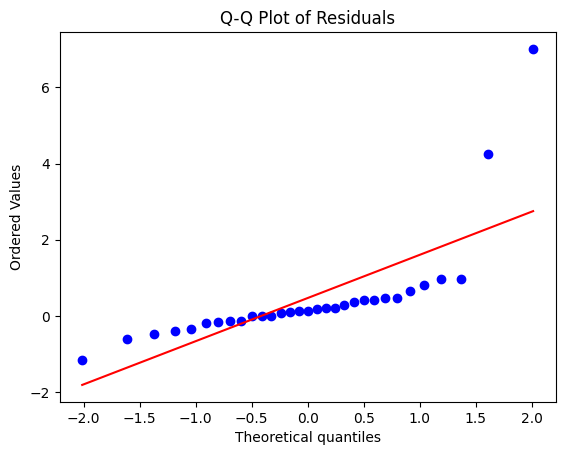

In [35]:
# 2. Normality of Residuals: Use the residuals of the Linear Regression model to check normality
# Train a simple linear regression model to get residuals
lr = LinearRegression(labelCol='crew', featuresCol='features')
lr_model = lr.fit(training)
lr_predictions = lr_model.transform(test)

# Extract residuals (true value - predicted value)
residuals = lr_predictions.withColumn('residuals', F.col('crew') - F.col('prediction'))
residuals_df = residuals.select('residuals').toPandas()

# Plot histogram of residuals
plt.hist(residuals_df['residuals'], bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot Q-Q plot to assess normality
import scipy.stats as stats
stats.probplot(residuals_df['residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

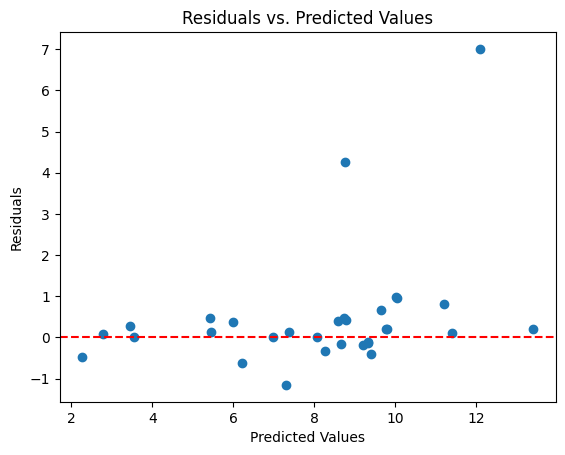

In [36]:
# 3. Homoscedasticity: Check if residuals have constant variance
plt.scatter(lr_predictions.toPandas()['prediction'], residuals_df['residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [37]:
# 4. Autocorrelation: Use the Durbin-Watson statistic to check for autocorrelation of residuals
# Durbin-Watson statistic is not directly available in PySpark; calculating manually
residuals_np = residuals_df['residuals'].values
dw_stat = np.sum(np.diff(residuals_np) ** 2) / np.sum(residuals_np ** 2)
print(f'Durbin-Watson Statistic: {dw_stat}')

Durbin-Watson Statistic: 1.7594433488133536


In [40]:
# Dummy variable for Cruise_line
# Note that we also use OneHotEncoder this time
from pyspark.ml.feature import OneHotEncoder,StringIndexer

# Create indexer for Cruise_line
stringIndexer = StringIndexer(inputCol='Cruise_line', outputCol='lineIndex')

# Update the dataframe
cruise = stringIndexer.fit(cruise).transform(cruise)

# Create labels/categories for Cruise_line
encoder = OneHotEncoder(inputCol="lineIndex",outputCol="lineCat")

# Update the dataframe
cruise = encoder.fit(cruise).transform(cruise)

# Take another look
cruise.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------+---------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|lineIndex|        lineCat|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------+---------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|     16.0|(19,[16],[1.0])|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|     16.0|(19,[16],[1.0])|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|      1.0| (19,[1],[1.0])|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|      1.0| (19,[1],[1.0])|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|      1.0| (19,[1],[1.0])|
+-----------+---

In [41]:
# Assemble numerical features (before scaling)
numerical_features = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
numerical_assembler = VectorAssembler(inputCols=numerical_features, outputCol='numerical_features')
cruise = numerical_assembler.transform(cruise)

# Apply StandardScaler to the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(cruise)
cruise = scaler_model.transform(cruise)

# Combine scaled numerical features with categorical features
final_assembler = VectorAssembler(
    inputCols=['scaled_features', 'lineCat'],
    outputCol='features'
)
cruise = final_assembler.transform(cruise)

In [42]:
cruise.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------+---------------+--------------------+--------------------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|lineIndex|        lineCat|  numerical_features|     scaled_features|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------+---------------+--------------------+--------------------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|     16.0|(19,[16],[1.0])|[6.0,30.276999999...|[-1.2723564208380...|(25,[0,1,2,3,4,5,...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|     16.0|(19,[16],[1.0])|[6.0,30.276999999...|[-1.2723564208380...|(25,[0,1,2,3,4,5,...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.

In [43]:
# Splitting the dataset into training and test sets
(training, test) = cruise.randomSplit([0.8, 0.2], seed=9165)

In [45]:
# Use linear regression
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol="crew",featuresCol="features")

# Set up the model
lrModel = lr.fit(training)
lr_prediction=lrModel.transform(test)
lr_prediction.select("prediction","crew","features").show(5)
evaluator = lrModel.evaluate(test)

+------------------+----+--------------------+
|        prediction|crew|            features|
+------------------+----+--------------------+
| 9.328889393474245| 9.2|(25,[0,1,2,3,4,5,...|
| 8.649011577410086| 8.5|(25,[0,1,2,3,4,5,...|
| 12.09429246383998|19.1|(25,[0,1,2,3,4,5,...|
|10.030670563580397|11.0|(25,[0,1,2,3,4,5,...|
| 9.191521291720564| 9.0|(25,[0,1,2,3,4,5,...|
+------------------+----+--------------------+
only showing top 5 rows



In [46]:
# Report R-squared as model evaluation

print('R Squared of this linear regression model is %g'%(evaluator.r2))

R Squared of this linear regression model is 0.797906


In [47]:
# Define regression models to test
models = {
    'Linear Regression': LinearRegression(labelCol='crew', featuresCol='features'),
    'Decision Tree Regressor': DecisionTreeRegressor(labelCol='crew', featuresCol='features'),
    'Random Forest Regressor': RandomForestRegressor(labelCol='crew', featuresCol='features'),
    'Gradient Boosting Regressor': GBTRegressor(labelCol='crew', featuresCol='features')
}

# Prepare the evaluator
evaluator = RegressionEvaluator(labelCol='crew', predictionCol='prediction')

# Dictionary to store results
results = []

# Training and evaluating each model
for model_name, model in models.items():
    # Train the model
    fitted_model = model.fit(training)

    # Make predictions
    predictions = fitted_model.transform(test)

    # Evaluate the model
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

    # Calculate Adjusted R-squared
    n = predictions.count()  # number of observations
    p = len(training.schema["features"].metadata["ml_attr"]["attrs"]["numeric"])  # number of predictors
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    # Calculate RSS (Residual Sum of Squares)
    rss = predictions.select(F.sum(F.pow(F.col("crew") - F.col("prediction"), 2)).alias("rss")).collect()[0]["rss"]

    # Calculate AIC and BIC
    aic = n * np.log(rss / n) + 2 * p
    bic = n * np.log(rss / n) + p * np.log(n)

    # Store results
    results.append({
        'Model': model_name,
        'R-squared': r2,
        'Adjusted R-squared': adjusted_r2,
        'RMSE': rmse,
        'MAE': mae,
        'AIC': aic,
        'BIC': bic
    })

# Convert results to a DataFrame for better visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Display the summary table of model performances
print(results_df)

                         Model  R-squared  Adjusted R-squared      RMSE  \
0            Linear Regression   0.797906            0.747382  1.540703   
1      Decision Tree Regressor   0.774926            0.718658  1.625940   
2      Random Forest Regressor   0.749559            0.686949  1.715121   
3  Gradient Boosting Regressor   0.775518            0.719397  1.623801   

        MAE        AIC        BIC  
0  0.700623  38.798822  47.402745  
1  0.836743  42.137355  50.741278  
2  0.881034  45.447983  54.051906  
3  0.726914  42.055727  50.659650  


In [48]:
results_df.sort_values(by='Adjusted R-squared', ascending=False).reset_index(drop=True)

,Model,R-squared,Adjusted R-squared,RMSE,MAE,AIC,BIC
0,Linear Regression,0.797906,0.747382,1.540703,0.700623,38.798822,47.402745
1,Gradient Boosting Regressor,0.775518,0.719397,1.623801,0.726914,42.055727,50.659650
2,Decision Tree Regressor,0.774926,0.718658,1.625940,0.836743,42.137355,50.741278
3,Random Forest Regressor,0.749559,0.686949,1.715121,0.881034,45.447983,54.051906
